# Exploratory Data Analysis on DOTA-v1.5 Dataset

In [3]:
# code borrowed from https://github.com/svdesai/eda-coco

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pdb
import os
from pycocotools.coco import COCO
from skimage import io

In [4]:
src_root = 'dota1_1024_ss/'
src_subset = 'trainval1024/images/'
src_file = src_root+'trainval1024/DOTA_trainval1024_ss.json'


coco_obj = COCO(src_file)

loading annotations into memory...
Done (t=1.64s)
creating index...
index created!


In [5]:
# Reading the json file
with open(src_file, 'r') as f:
    root = json.load(f)

root.keys()

dict_keys(['images', 'categories', 'annotations'])

## High Level Information

In [6]:
# Basic High Level Information

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]


print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Number of images:  21046
Number of bounding boxes:  245807
Number of classes:  15
Max min avg height:  1024 1024 1024
Max min avg width:  1024 1024 1024


## Distribution of objects across images

In [7]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in root['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

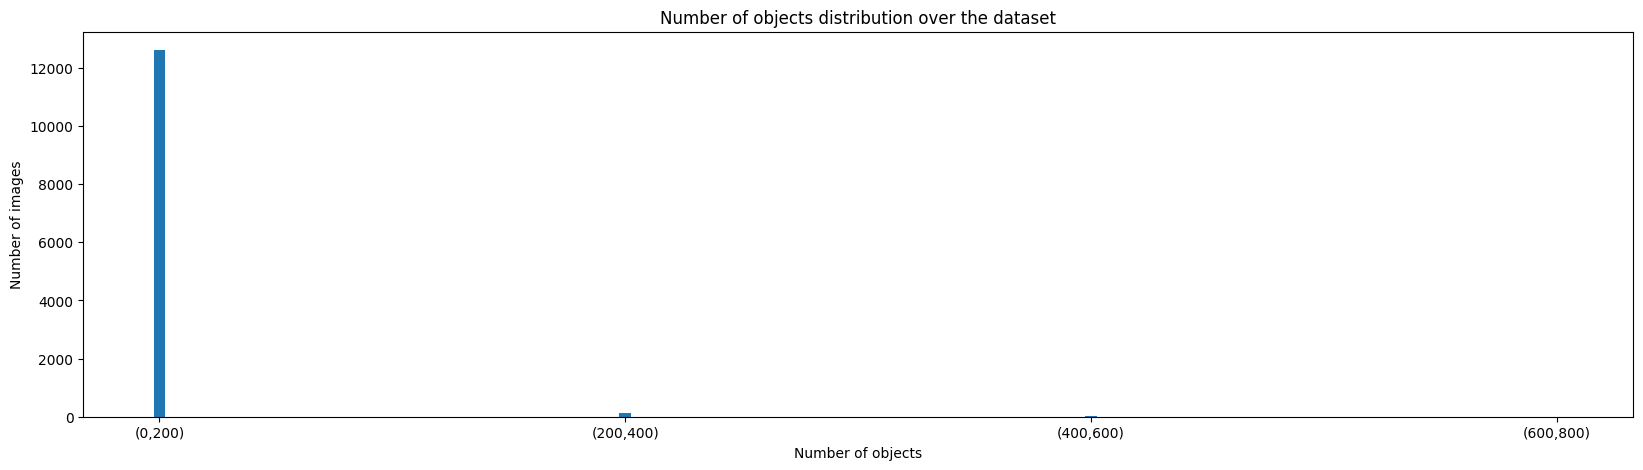

Number of images having atleast one box:  12766
Min number of boxes per image:  1
Max number of boxes per image:  648
Avg number of boxes per image:  19


In [10]:
out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+200,200), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(20,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

## Class wise distribution of objects

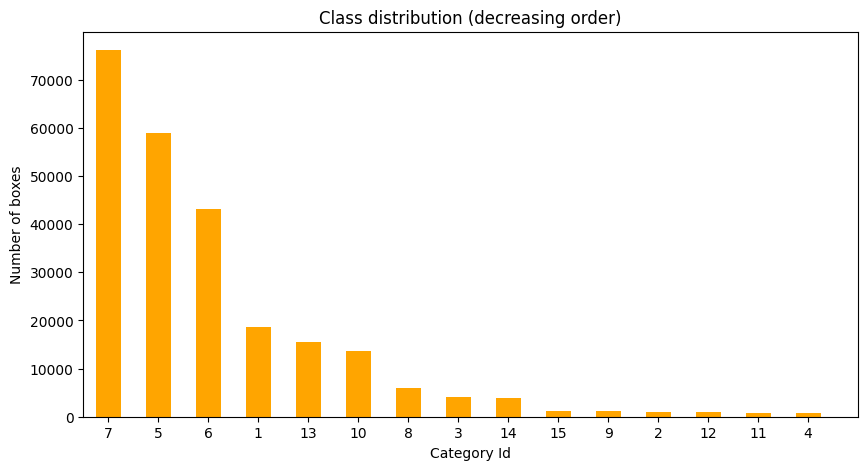

1 -> plane, 2 -> baseball-diamond, 3 -> bridge, 4 -> ground-track-field, 5 -> small-vehicle, 6 -> large-vehicle, 7 -> ship, 8 -> tennis-court, 9 -> basketball-court, 10 -> storage-tank, 11 -> soccer-ball-field, 12 -> roundabout, 13 -> harbor, 14 -> swimming-pool, 15 -> helicopter, 

In [11]:
# Class distribution
class2nboxes = {} 

for ann in root['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()



categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

## Class wise bounding box area distribution

In [12]:
# Class wise bounding box area distribution

bbox_areas = {} # key: class index, value -> a list of bounding box areas

for ann in root['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    
    if area <= 0.0:
        continue
    
    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

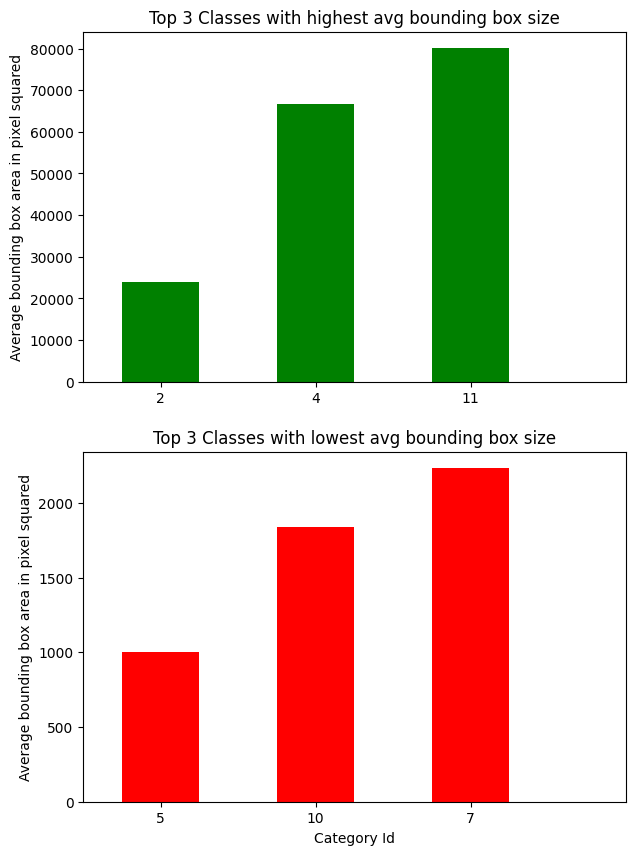

1 -> plane, 2 -> baseball-diamond, 3 -> bridge, 4 -> ground-track-field, 5 -> small-vehicle, 6 -> large-vehicle, 7 -> ship, 8 -> tennis-court, 9 -> basketball-court, 10 -> storage-tank, 11 -> soccer-ball-field, 12 -> roundabout, 13 -> harbor, 14 -> swimming-pool, 15 -> helicopter, 

In [13]:
top = min(3, len(bbox_avg_areas))

plt.figure(figsize=(7,10))

y = [item[1] for item in bbox_avg_areas[-top:]]
x = [item[0] for item in bbox_avg_areas[-top:]]

y2 = [item[1] for item in bbox_avg_areas[:top]]
x2 = [item[0] for item in bbox_avg_areas[:top]]

plt.subplot(211)
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='green')
plt.xlim(-0.5,len(y))
# plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with highest avg bounding box size')


plt.subplot(212)
plt.bar(np.arange(len(y2)),y2, width=0.5,tick_label=x2,color='red')
plt.xlim(-0.5,len(y2))
plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with lowest avg bounding box size')
plt.show()




categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

## Viewing random images

['ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'harbor', 'harbor', 'harbor', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'ship', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship']


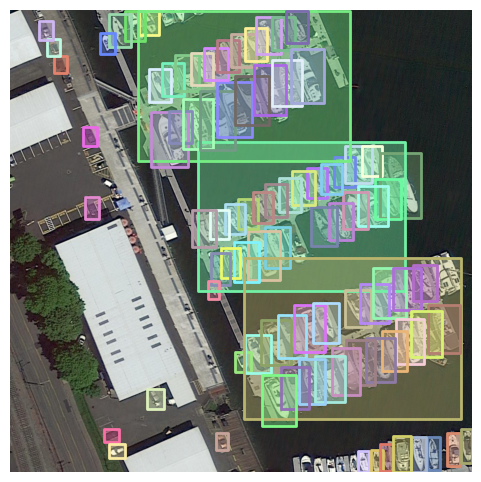

In [16]:
# generate a random image
imgIds = [i['id'] for i in root['images']]
catIds = [i['id'] for i in root['categories']]
img = coco_obj.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
img_path= os.path.join(src_root, src_subset, img['file_name'])
I = io.imread(img_path)

# plot annotations
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(I)
annIds = coco_obj.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_obj.loadAnns(annIds)

#  disable segmentation
for a in anns:
    if 'segmentation' in a.keys():
        a['segmentation'] = []
coco_obj.showAnns(anns, draw_bbox=True)
classes = [categ_map[a['category_id']] for a in anns]
print(classes)